In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

import torch
import timm
import segmentation_models_pytorch as smp
from torchinfo import summary
from tqdm import tqdm

from extras import simulation_helper 

In [2]:
from models.combo_net import FocalWin

model = FocalWin(num_classes=6)

c:\Users\Sowmen\anaconda3\envs\DLenv\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


_IncompatibleKeys(missing_keys=['patch_embed.proj.weight'], unexpected_keys=[])


In [3]:
from extras.sim_dataset import SimDataset
from torchvision import transforms
from torch.utils.data import DataLoader

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

train_set = SimDataset(2000, transform = trans)
train_loader = DataLoader(train_set, batch_size=6, shuffle=True, num_workers=0)
val_set = SimDataset(500, transform = trans)
valid_loader = DataLoader(val_set, batch_size=8, shuffle=False, num_workers=0)

torch.Size([6, 3, 256, 256])


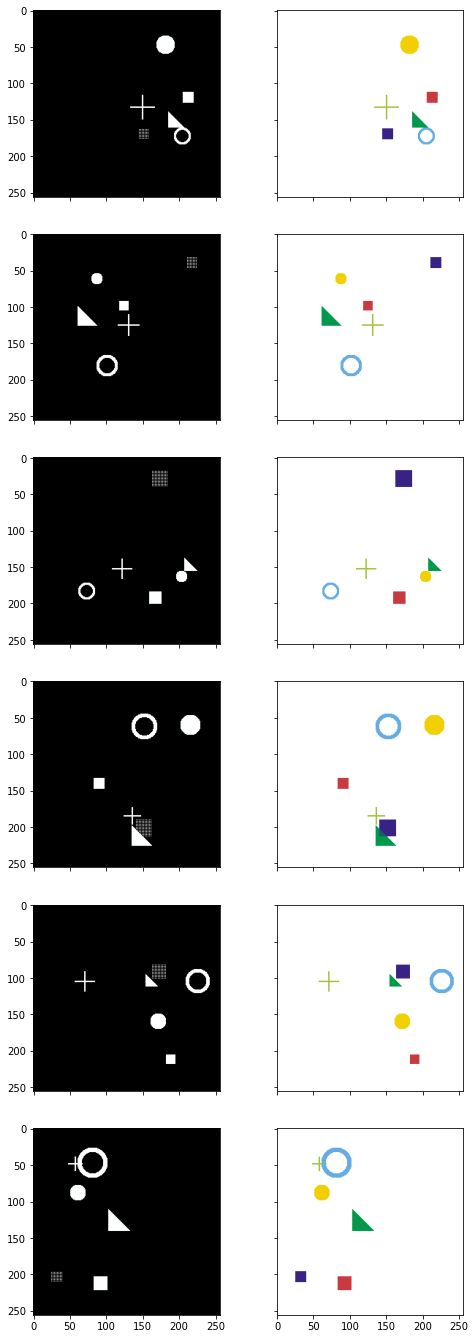

In [3]:
batch = next(iter(train_loader))
images = batch["image"].to('cuda')
elas = batch["ela"].to('cuda')
gt = batch["mask"].to('cuda')
print(images.shape)

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in images.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [simulation_helper.masks_to_colorimg(x) for x in gt.cpu().numpy()]

simulation_helper.plot_side_by_side([input_images_rgb, target_masks_rgb])

In [4]:
from utils import AverageMeter, EarlyStopping

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss = torch.nn.BCEWithLogitsLoss()
es = EarlyStopping(patience=5, mode="min")

In [5]:
model.to('cuda')

def train_epoch(model, train_loader, optimizer, criterion, epoch):
    model.train()

    total_loss = AverageMeter()

    for batch in tqdm(train_loader, desc=f"Train epoch {epoch}"):
        images = batch["image"].to('cuda')
        elas = batch["ela"].to('cuda')
        gt = batch["mask"].to('cuda')

        optimizer.zero_grad()
        label_tensor, pred_mask = model(images, elas)

        bce_loss = criterion(pred_mask, gt)
        bce_loss.backward()

        optimizer.step()
            
        # ---------------------Batch Loss Update-------------------------
        total_loss.update(bce_loss.item(), train_loader.batch_size)

    print("Train Loss", total_loss.avg)
    return total_loss.avg
    

def valid_epoch(model, valid_loader, criterion, epoch):
    model.eval()

    total_loss = AverageMeter()
    
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc=f"Valid epoch {epoch}"):
            images = batch["image"].to('cuda')
            elas = batch["ela"].to('cuda')
            gt = batch["mask"].to('cuda')
                    
            
            label_tensor, pred_mask = model(images, elas)

            bce_loss = criterion(pred_mask, gt)

            # ---------------------Batch Loss Update-------------------------
            total_loss.update(bce_loss.item(), valid_loader.batch_size)

    print("Valid Loss", total_loss.avg)
    return total_loss.avg


for epoch in range(10):
    train_loss = train_epoch(model, train_loader, optimizer, loss, epoch)
    valid_loss = valid_epoch(model, valid_loader, loss, epoch)

    es(valid_loss, model, model_path="sim_test.h5")
    if es.early_stop:
        print("Early stopping")
        break

Train epoch 0: 100%|██████████| 334/334 [05:02<00:00,  1.10it/s]


Train Loss 0.033965411497012314


Valid epoch 0: 100%|██████████| 63/63 [00:40<00:00,  1.55it/s]


Valid Loss 0.006114039629224747
Validation score improved (inf --> 0.006114039629224747). Saving model!


Train epoch 1: 100%|██████████| 334/334 [08:45<00:00,  1.57s/it]


Train Loss 0.004316251915266102


Valid epoch 1: 100%|██████████| 63/63 [00:40<00:00,  1.57it/s]


Valid Loss 0.003630523562490467
Validation score improved (0.006114039629224747 --> 0.003630523562490467). Saving model!


Train epoch 2: 100%|██████████| 334/334 [08:44<00:00,  1.57s/it]


Train Loss 0.003611915873107082


Valid epoch 2: 100%|██████████| 63/63 [00:39<00:00,  1.58it/s]


Valid Loss 0.003316345765063214
Validation score improved (0.003630523562490467 --> 0.003316345765063214). Saving model!


Train epoch 3: 100%|██████████| 334/334 [08:43<00:00,  1.57s/it]


Train Loss 0.003217109247573657


Valid epoch 3: 100%|██████████| 63/63 [00:09<00:00,  6.35it/s]


Valid Loss 0.003073113685887721
Validation score improved (0.003316345765063214 --> 0.003073113685887721). Saving model!


Train epoch 4: 100%|██████████| 334/334 [02:12<00:00,  2.52it/s]


Train Loss 0.0030913337630158414


Valid epoch 4: 100%|██████████| 63/63 [00:09<00:00,  6.88it/s]


Valid Loss 0.003009944089821407
EarlyStopping counter: 1 out of 5


Train epoch 5: 100%|██████████| 334/334 [02:12<00:00,  2.52it/s]


Train Loss 0.003012640400326805


Valid epoch 5: 100%|██████████| 63/63 [00:09<00:00,  6.66it/s]


Valid Loss 0.0029946002584423813
EarlyStopping counter: 2 out of 5


Train epoch 6: 100%|██████████| 334/334 [02:12<00:00,  2.51it/s]


Train Loss 0.002970780160216737


Valid epoch 6: 100%|██████████| 63/63 [00:09<00:00,  6.95it/s]


Valid Loss 0.0029475284104664174
Validation score improved (0.003073113685887721 --> 0.0029475284104664174). Saving model!


Train epoch 7: 100%|██████████| 334/334 [02:12<00:00,  2.51it/s]


Train Loss 0.0029294972850322097


Valid epoch 7: 100%|██████████| 63/63 [00:09<00:00,  6.91it/s]


Valid Loss 0.002892042746737836
EarlyStopping counter: 1 out of 5


Train epoch 8: 100%|██████████| 334/334 [02:12<00:00,  2.52it/s]


Train Loss 0.002879272429774443


Valid epoch 8: 100%|██████████| 63/63 [00:09<00:00,  6.93it/s]


Valid Loss 0.002843392835486503
Validation score improved (0.0029475284104664174 --> 0.002843392835486503). Saving model!


Train epoch 9: 100%|██████████| 334/334 [02:12<00:00,  2.52it/s]


Train Loss 0.002871777405014295


Valid epoch 9: 100%|██████████| 63/63 [00:09<00:00,  6.86it/s]

Valid Loss 0.0028661186991643813
EarlyStopping counter: 1 out of 5


In [6]:
model = FocalWin(6)
model.load_state_dict(torch.load('sim_test.h5'))
model.to('cuda')
model.eval();

_IncompatibleKeys(missing_keys=['patch_embed.proj.weight'], unexpected_keys=[])


c:\Users\Sowmen\anaconda3\envs\DLenv\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(5, 6, 256, 256)


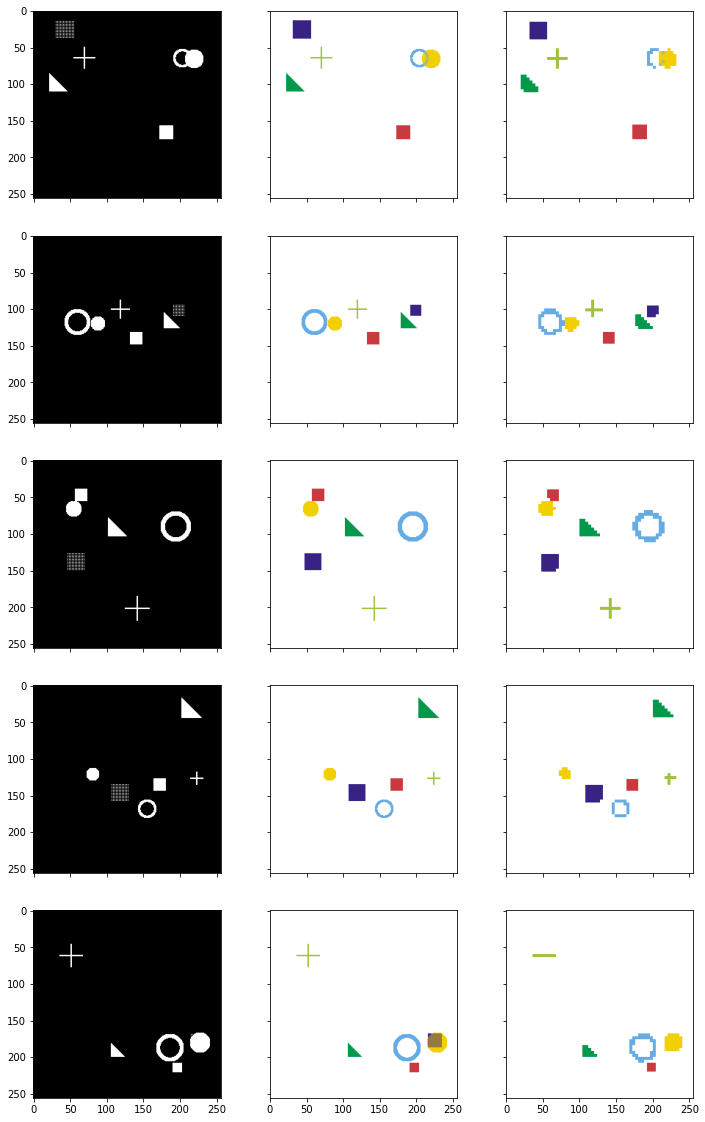

In [7]:
test_dataset = SimDataset(5, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=0)

# Get the first batch
data = next(iter(test_loader))
inputs = data['image'].to('cuda')
labels = data['mask'].to('cuda')
elas = data['ela'].to('cuda')


# Predict
label, pred = model(inputs, elas)
# The loss functions include the sigmoid function.
pred = torch.nn.functional.sigmoid(pred)
pred = pred.data.cpu().detach().numpy()
print(pred.shape)

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [simulation_helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [simulation_helper.masks_to_colorimg(x) for x in pred]

simulation_helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])